### Edgar Moises Hernandez-Gonzalez
#### 12/03/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 50.35%
##### Kappa = 0.3380

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 49.65%
##### Kappa = 0.3287

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 49.65%
##### Kappa = 0.3287

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     TimeDistributed, LSTM, GRU, ConvLSTM2D,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (224, 224) #ancho, alto
  datos = np.zeros((288,224,224))
  temporal = np.zeros((2816,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #2 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 224, 224)
(288, 224, 224)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

63.61667794442416
51.945422955242144
0.003040424208839134
0.00513285370187634


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 64.0
x_test /= 64.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.99401057
0.81164724
4.750663e-05
8.0200836e-05


In [0]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 1, 224, 224, 1)
(288, 1, 224, 224, 1)


In [0]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(16))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

"def CNN_2D_LSTM_TD_BN():\n  model = Sequential()\n  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same'),\n                            input_shape=x_train.shape[1:]))\n  model.add(TimeDistributed(BatchNormalization()))\n  model.add(TimeDistributed(Activation('relu')))\n  model.add(TimeDistributed(MaxPool2D((2,2))))\n  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))\n  model.add(TimeDistributed(BatchNormalization()))\n  model.add(TimeDistributed(Activation('relu')))\n  model.add(TimeDistributed(MaxPool2D((2,2))))\n  model.add(TimeDistributed(Conv2D(128, (3,3), padding='same')))\n  model.add(TimeDistributed(BatchNormalization()))\n  model.add(TimeDistributed(Activation('relu')))\n  model.add(TimeDistributed(Flatten()))\n  model.add(LSTM(32))\n  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh\n  model.add(Dense(n_classes, activation='softmax'))\n\n  optimizer = Adam(lr=1e-4)\n  model.compile(optimizer = optimizer,\n                loss = '

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu',)))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(16))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [0]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
'''def Conv_LSTM_2D_BN():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

Iteration: 1
288/288 - 1s - loss: 2.1163 - acc: 0.4618
kappa:  0.28240740740740744
confusion matrix:
 [[32 24  7  9]
 [35 32  2  3]
 [13  1 31 27]
 [ 1  1 32 38]]


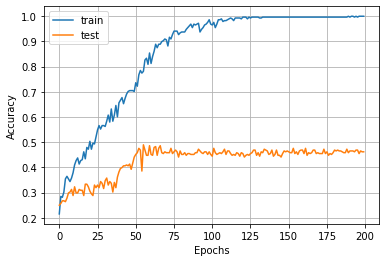

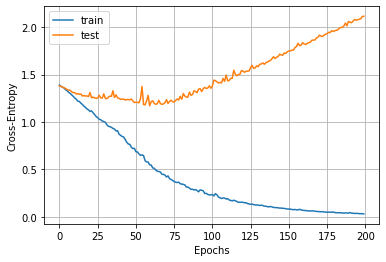

Iteration: 2
288/288 - 1s - loss: 1.8041 - acc: 0.4722
kappa:  0.2962962962962963
confusion matrix:
 [[29 28  6  9]
 [26 38  7  1]
 [ 5  7 22 38]
 [ 2  3 20 47]]


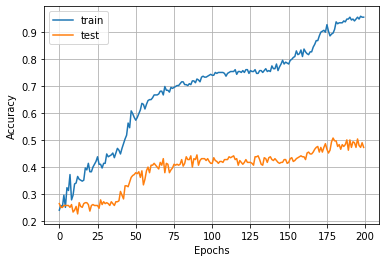

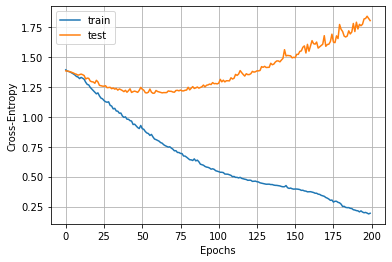


Resultados:
loss: [2.1162716150283813, 1.8040697971979778]
accuracy: [0.46180555, 0.4722222]
kappa: [0.28240740740740744, 0.2962962962962963]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  model = Conv_LSTM_2D()
  #model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=200, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_13 (ConvLSTM2D) (None, 224, 224, 32)      38144     
_________________________________________________________________
dropout_15 (Dropout)         (None, 224, 224, 32)      0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1605632)           0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                25690128  
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 68        
Total params: 25,728,340
Trainable params: 25,728,340
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4670
std: (+/- 0.0052)
Mean Kappa: 0.2894
std: (+/- 0.0069)
Max Accuracy: 0.4722
Max Kappa: 0.2963
